In [1]:
import tensorflow as tf
from tensorflow import keras
import ludopy
from tqdm import tqdm
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [2]:

def flatten(l):
    return [item for sublist in l for item in sublist]

In [3]:
def get_state_rep(player_pieces, enemy_pieces, dice = None):
    next_state = []
    
    if isinstance(dice, int):
        next_state.append(np.concatenate([keras.utils.to_categorical(player_pieces + flatten(enemy_pieces), num_classes=60).flatten(), keras.utils.to_categorical(dice-1, num_classes=6)]))
    else:
        for di in np.arange(1,6+1):
            next_state.append(np.concatenate([keras.utils.to_categorical(player_pieces + flatten(enemy_pieces), num_classes=60).flatten(), keras.utils.to_categorical(di-1, num_classes=6)]))
    return np.array(next_state)

In [4]:
class Aget:
    def __init__(self):
        self.discount_factor = 0.9
        self.epsilon = 0.5
        self.lr = 0.001
        self.pos_pices = np.arange(4) 
        self.memory = deque(maxlen = 400) #[] #Lav til en dqueu
        self.preformence_hist = []
        
        self.state_size = 4*4*60+6
        self.action_size = 4
        self.make_model()
        
    def make_model(self):
        self.model = keras.Sequential()
        self.model.add(keras.layers.Dense(16, activation="relu", input_shape=(self.state_size,)))
        self.model.add(keras.layers.Dense(32, activation="relu"))
        self.model.add(keras.layers.Dense(self.action_size, activation="linear"))
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate = self.lr), loss="mse", metrics=["mae"])
        self.epochs_num = 0
        
    def chose_action(self, state, move_pieces):
        action = random.choice(move_pieces)
        if np.random.rand() > self.epsilon:
            not_moverble_pices = np.delete(self.pos_pices, move_pieces)

            action = self.model.predict(state)[0]
            action[not_moverble_pices] = np.min(action) - 1

            action = np.argmax(action)
        return action
    
    def add_to_memory(self, to_momoryrise):
        self.memory.append(to_momoryrise)
    
    def train_on_memory(self, train_size):
        batch_indexs = np.random.choice(np.arange(len(self.memory)), size=min(train_size, len(self.memory)), replace=False)
        train_batch = np.array(self.memory)[batch_indexs]
        
        for state, action, reward, next_states, there_is_a_winner, move_pieces in train_batch:
            not_moverble_pices = np.delete(self.pos_pices, move_pieces)
            target = reward

            if not there_is_a_winner:
                target = reward + self.discount_factor * np.amax(self.model.predict(next_states))

            target_correcetd = self.model.predict(state)
            target_correcetd[0][action] = target
            target_correcetd[0][not_moverble_pices] = 0.0

            hist = self.model.fit(state, target_correcetd, epochs=self.epochs_num+1, verbose=0, initial_epoch=self.epochs_num)
            self.preformence_hist.append(np.array(list(hist.history.values())).flatten())
    
    

In [5]:
agent = Aget()

In [6]:
game = ludopy.Game()

In [7]:
n_rounds = 5000

winners = []

for _ in tqdm(range(n_rounds)):
    there_is_a_winner = False

    game.reset()

    while not there_is_a_winner:
        (dice, move_pieces, player_pieces, enemy_pieces, player_is_a_winner, there_is_a_winner), player_i = game.get_observation()
        
        if player_i == 0:
            state = get_state_rep(player_pieces, enemy_pieces, dice)

            if len(move_pieces):
                action = agent.chose_action(state, move_pieces)
            else:
                action = -1
        else:
            if len(move_pieces):
                action = random.choice(move_pieces)
            else:
                action = -1
        
        (new_dice, new_move_pieces, new_player_pieces, new_enemy_pieces, player_is_a_winner, there_is_a_winner) = game.answer_observation(action)
        
        
        if player_i == 0:
            if player_is_a_winner:
                reward = 100
            else:
                reward = 0


            next_states = get_state_rep(new_player_pieces, new_enemy_pieces)

            agent.add_to_memory([state, action, reward, next_states, there_is_a_winner, move_pieces])
        
        if there_is_a_winner:
            winners.append(game.get_winner_of_game())
        
    agent.train_on_memory(64)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [6:34:36<00:00,  4.74s/it]


In [8]:
agent.model.save("deep_q.h5")
np.save("preformence_hist.npy", agent.preformence_hist)
np.save("winners.npy", winners)

In [9]:
import os
from datetime import datetime
if datetime.now().hour < 9 or datetime.now().hour > 21:
    os.system('shutdown -s -t 0')

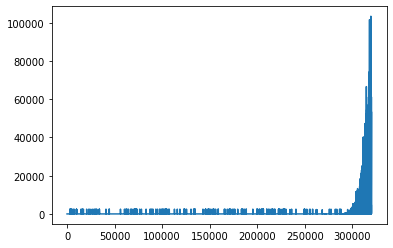

In [14]:
plt.plot(np.array(agent.preformence_hist)[:,0])

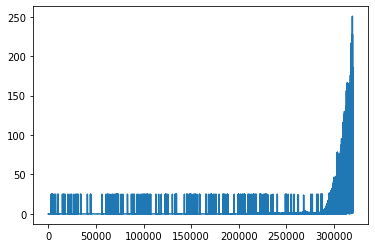

In [15]:
plt.plot(np.array(agent.preformence_hist)[:,1])